In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation 
from celluloid import Camera
from matplotlib import cm
import sys

sys.path.append("src")
from hamiltonian_gas import HamiltonianGasSystem
from gas_dynamics import GasDynamics
import gas_potential
import gas_interaction

In [2]:
# Input ###########
dimension: int = 2
num_particles: int = 50
box_size: float = 1.

## initial condition
coordinates = (box_size*np.random.rand(num_particles, dimension)/2)
momentums = 0.1*np.random.normal(0, 0.5, (num_particles, dimension))
###################

half_box_size: float = box_size/2


In [3]:
# gas system with 1/d**2 like potential
gas = HamiltonianGasSystem(m=1,
                           outer_potential=gas_potential.SimpleQuadraticPotential(a=0.5),
                           interaction=gas_interaction.M1Interaction(r0=0.02, u0=0.05),
                          )
gas.initial_energy = gas.energy(coordinates, momentums)
print(gas.initial_energy)

gas_dynamics = GasDynamics(gas.d_hamiltonian_d_coordinates, gas.d_hamiltonian_d_momentums, half_box_size)

4.301861662213401


Text(0, 0.5, 'pair potential')

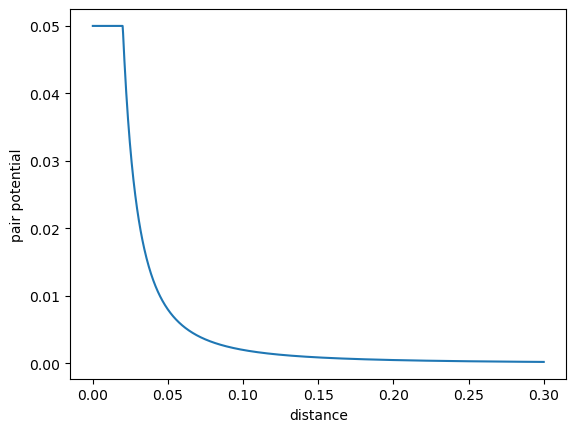

In [4]:
# interaction potential
xs = np.linspace(0.0001,0.3,1000)
ys = [gas.interaction.pair_potential(0, x) for x in xs]
plt.plot(xs, ys)
plt.xlabel("distance")
plt.ylabel("pair potential")


In [5]:
# Run the simulation
# Parameters ######
dt = 2**-9
num_steps = 10000
###################


p_t = [momentums]
r_t = [coordinates]

energy_t = [ gas.energy(r_t[-1], p_t[-1]) ]
kin_t = [gas.kinetic_energy(p_t[-1]) ]
t = [0]
for i in range(num_steps):
    r, p = gas_dynamics.sie(r_t[-1], p_t[-1], dt)
    gas_dynamics.walls(r, p)
    t.append(t[-1] + dt)
    r_t.append(r)
    p_t.append(p)
    kin_t.append(gas.kinetic_energy(p_t[-1]))
    energy_t.append(gas.energy(r_t[-1], p_t[-1]) )


p_t = np.array(p_t)
r_t = np.array(r_t)
energy_t = np.array(energy_t)
kin_t = np.array(kin_t)
t = np.array(t)

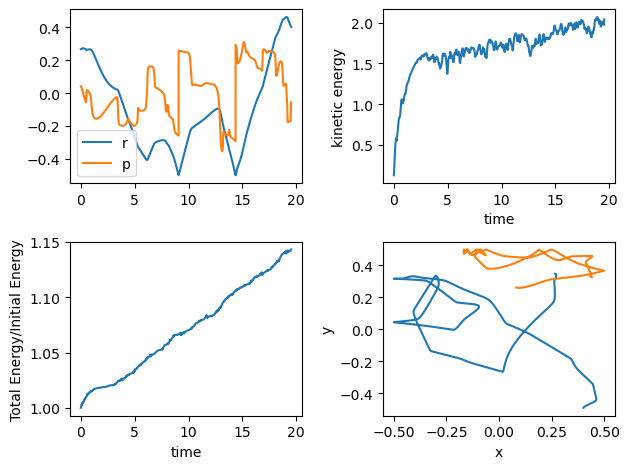

In [6]:


fig, ax = plt.subplots(2,2)
ax[0,0].plot(t, r_t[:,0,0], label='r' )
ax[0,0].plot(t, p_t[:,0,0], label='p' )
ax[0,0].legend()
ax[1,0].plot(t, energy_t/gas.initial_energy)
ax[1,0].set_ylabel('Total Energy/Initial Energy')
ax[1,0].set_xlabel('time')


ax[0,1].plot(t, kin_t)
ax[0,1].set_xlabel('time')
ax[0,1].set_ylabel('kinetic energy')


ax[1,1].plot([r[0][0] for r in r_t], [r[0][1] for r in r_t])
ax[1,1].plot([r[1][0] for r in r_t], [r[1][1] for r in r_t])

ax[1,1].set_xlabel("x")
ax[1,1].set_ylabel("y")

fig.tight_layout()

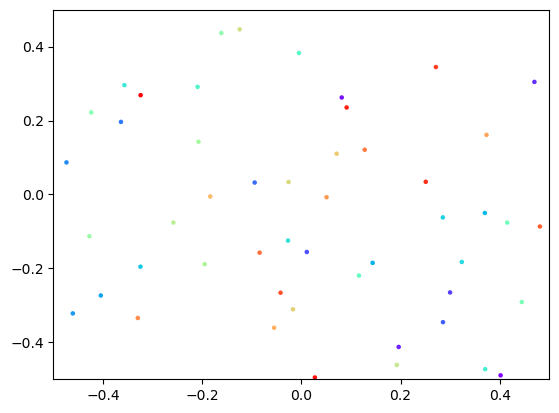

In [7]:
colors = cm.rainbow(np.linspace(0, 1, num_particles))
camera = Camera(plt.figure())
for r in r_t[::8]:
    plt.scatter(*r.T, c=colors, s=5)
    plt.xlim([-half_box_size,half_box_size])
    plt.ylim([-half_box_size, half_box_size])
    camera.snap()
anim = camera.animate(blit=True)
anim.save('scatter.mp4', fps = 40)

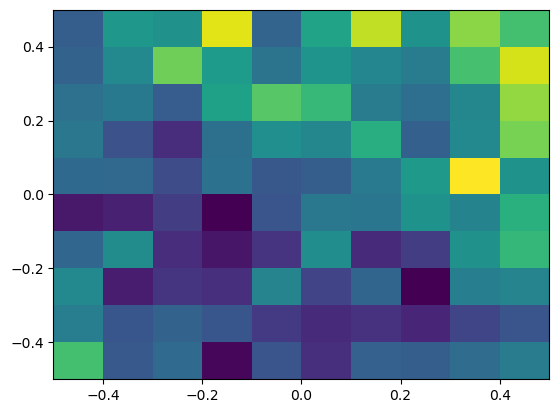

In [8]:
# Heat map of the position of the particles
plt.hist2d( r_t[:,:,0].flatten(), r_t[:,:,1].flatten(),  )
plt.show()